In [1]:
import re
import os
import warnings
from math import floor
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning


from sklearn.manifold import TSNE

In [2]:
strategies = ['None', 'Specific', 'Generic']
temperatures = ['0.0', '0.7']
variations = ['0', '1', '2']
recursions = ['0', '1']

# Pattern for extracting features
regex_patterns = {
    'Powderkg': r'Powderkg = (\d+)',
    'wc': r'wc = ([\d.]+)',
    'materials': r'materials = ([\d./]+)',
    'curing': r'curing = (.+?)(?:\n|$)'
}

def extract_data_for_given_run(pattern):
    """
    :param pattern: Pattern of filenames holding results of experimental runs
    :return: Dataframe with all results for the given filename pattern
    """
    matching_filenames = []
    # Iterate through the files in the directory
    dir_name = 'Results/ID'
    for filename in os.listdir(dir_name):
        match = re.match(pattern, filename)
        if match:
            matching_filenames.append(os.path.join(dir_name, filename))
    all_results_df = pd.DataFrame()
    warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
    for i, filename in enumerate(matching_filenames):
        results_sample_df = pd.read_csv(filename)
        for col, pattern in regex_patterns.items():
            all_results_df[f'{col} {i}'] = results_sample_df['Formulation'].str.extract(pattern, expand=False)
            if col.startswith('materials'):
                all_results_df[f'{col} {i}'] = all_results_df[f'{col} {i}'].str[:3]
            if col.startswith('curing'):
                all_results_df[f'{col} {i}'][all_results_df[f'{col} {i}'].astype(str).str.startswith('Heat')] = 0
                all_results_df[f'{col} {i}'][all_results_df[f'{col} {i}'].astype(str).str.startswith('heat')] = 0
                all_results_df[f'{col} {i}'][all_results_df[f'{col} {i}'].astype(str).str.startswith('Ambient')] = 1
                all_results_df[f'{col} {i}'][all_results_df[f'{col} {i}'].astype(str).str.startswith('ambient')] = 1
            all_results_df[f'{col} {i}'] = all_results_df[f'{col} {i}'].astype(float)
    return all_results_df, matching_filenames

pattern = fr'gpt-3.5-turbo_None 0_prompt_experiment_(\d+)_temp_0.0_target_(\d+)_\%_Dev_Budget_(\d+)_recursive_0_(\d+)\.csv'
extract_data_for_given_run(pattern)

(   Powderkg 0  wc 0  materials 0  curing 0  Powderkg 1  wc 1  materials 1  \
 0       360.0  0.45          0.7       1.0       360.0  0.45          0.7   
 1       450.0  0.60          0.5       0.0       450.0  0.60          0.5   
 2       410.0  0.55          0.6       0.0       410.0  0.55          0.6   
 3       430.0  0.50          0.7       0.0       430.0  0.50          0.7   
 4       380.0  0.60          0.5       1.0       380.0  0.60          0.5   
 5       400.0  0.55          0.6       1.0       390.0  0.45          0.6   
 6       390.0  0.50          0.7       0.0       400.0  0.50          0.7   
 7       440.0  0.45          0.6       1.0       420.0  0.55          0.5   
 8       450.0  0.60          0.7       1.0       440.0  0.60          0.7   
 9       420.0  0.50          0.6       0.0       450.0  0.45          0.6   
 
    curing 1  Powderkg 2  wc 2  materials 2  curing 2  Powderkg 3  wc 3  \
 0       1.0       360.0  0.45          0.7       1.0       360.0

In [39]:
all_combinations = list(product(strategies, temperatures, recursions))

def compute_std_over_different_runs(df, number_of_iterations=10):
    df = df.copy()
    std_for_each_run = []
    for i in range(number_of_iterations):
        df[i] = df[i].fillna(df[i].mean())
        max = df[i].max()
        min = df[i].min()
        if max - min == 0:
            std = df[i].std()
        else:
            std = df[i].std() / (max - min)
        std_for_each_run.append(std)
    return np.array(std_for_each_run)


def normalize_feature(feature):
    max = feature.max()
    if max == 0:
        max = 1
    return feature / max


def get_max(df):
    max = np.max(df)
    if max == 0:
        max = 1
    return max


# DEPRECATED -> keep for comparison (in the functions below we use a simpler way of estimating the std)
def compute_overall_std(df_1, df_2, df_3, df_4, number_of_iterations=10):
    """
    :param df_1: powders df
    :param df_2: wc df
    :param df_3: materials df
    :param df_4: curing df
    :param number_of_iterations: the number of iterations when running a specific experiment
    :return: an approximation for an std at the recipe level (alternative computations might be insightful as well)
    """
    df_1 = df_1.copy()
    df_2 = df_2.copy()
    df_3 = df_3.copy()
    df_4 = df_4.copy()

    std_for_each_run = []
    recipe_vectors_for_each_run = []

    for i in range(number_of_iterations):
        df_1[i] = df_1[i].fillna(df_1[i].mean())
        df_2[i] = df_2[i].fillna(df_2[i].mean())
        df_3[i] = df_3[i].fillna(df_3[i].mean())
        df_4[i] = df_4[i].fillna(df_4[i].mean())

        df_1[i] = normalize_feature(df_1[i])
        square_1 = np.square(df_1[i].values)

        df_2[i] = normalize_feature(df_2)
        square_2 = np.square(df_2[i].values)

        df_3[i] = normalize_feature(df_3[i])
        square_3 = np.square(df_3[i].values)

        df_4[i] = normalize_feature(df_4[i])
        square_4 = np.square(df_4[i].values)

        overall_std = np.sqrt(np.std(square_1) + np.std(square_2) + np.std(square_3) + np.std(square_4))
        euclidean_recipe_value = np.sqrt(np.mean(square_1) + np.mean(square_2) + np.mean(square_3) + np.mean(square_4))
        std_for_each_run.append(overall_std)
        recipe_vectors_for_each_run.append(euclidean_recipe_value)

    return recipe_vectors_for_each_run, std_for_each_run


def find_matching_files(pattern_0, pattern_1,pattern_2):
    filenames = []

    dir_name = 'Results/ID'
    for filename in os.listdir(dir_name):
        match = re.match(pattern_0, filename) or re.match(pattern_1, filename) or re.match(pattern_2, filename)
        if match:
            filenames.append(os.path.join(dir_name, filename))
    return filenames


def extract_data_for_given_run_for_all_variations(pattern_0, pattern_1, pattern_2):
    all_filenames = find_matching_files(pattern_0, pattern_1, pattern_2)

    all_runs_df = pd.DataFrame()
    warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
    for i, filename in enumerate(all_filenames):
        results_sample_df = pd.read_csv(filename)

        for col, pattern in regex_patterns.items():
            all_runs_df[f'{col} {i}'] = results_sample_df['Formulation'].str.extract(pattern, flags=re.DOTALL,
                                                                                     expand=False)
            if col.startswith('materials'):
                all_runs_df[f'{col} {i}'] = all_runs_df[f'{col} {i}'].str[:3]
            if col.startswith('curing'):
                all_runs_df[f'{col} {i}'][all_runs_df[f'{col} {i}'].astype(str).str.startswith('Heat')] = 0
                all_runs_df[f'{col} {i}'][all_runs_df[f'{col} {i}'].astype(str).str.startswith('heat')] = 0
                all_runs_df[f'{col} {i}'][all_runs_df[f'{col} {i}'].astype(str).str.startswith('Ambient')] = 1
                all_runs_df[f'{col} {i}'][all_runs_df[f'{col} {i}'].astype(str).str.startswith('ambient')] = 1

    return all_runs_df, all_filenames


def count_unique_tsne_points(tsne_result):
    precision = 2  # Adjust this based on your data and desired precision
    rounded_coordinates = np.round(tsne_result, precision)

    coordinate_tuples = [tuple(coord) for coord in rounded_coordinates]

    unique = {coord: coordinate_tuples.count(coord) for coord in set(coordinate_tuples)}

    return len(unique.items())


def compute_avg_tsne_dist(tsne_result, top_result):
    distances = []
    for vector in tsne_result:
        distances.append(np.linalg.norm(vector - top_result     ))
    return np.mean(distances)


def compute_avg_grad(vector):
    diffs = np.array([])
    for i in range(len(vector)):
        if i < len(vector) - 1:
            grad = vector[i + 1] - vector[i]
            diffs = np.append(diffs, grad)
    return np.mean(diffs)


def get_material_dfs_from_all_results_df():
    features = ['Powderkg', 'wc', 'materials', 'curing']
    powders = {}
    wc_ratios = {}
    materials = {}
    curing = {}

    for feature in features:
        for i in range(len(matching_filenames)):
            if feature == 'Powderkg':
                powders[f'{feature} {i}'] = list(all_results_df[f'{feature} {i}'].astype(float).values)
            elif feature == 'wc':
                wc_ratios[f'{feature} {i}'] = list(all_results_df[f'{feature} {i}'].astype(float).values)
            elif feature == 'materials':
                materials[f'{feature} {i}'] = list(all_results_df[f'{feature} {i}'].astype(float).values)
            elif feature == 'curing':
                curing[f'{feature} {i}'] = list(all_results_df[f'{feature} {i}'].astype(float).values)

    return pd.DataFrame(powders).T, pd.DataFrame(wc_ratios).T, pd.DataFrame(materials).T, pd.DataFrame(curing).T


def add_current_iteration_results_to_recipe_vectors(recipes_df, materials_df, i):
    powders = materials_df.feature_dfs[0]
    wc = materials_df.feature_dfs[1]
    materials = materials_df.feature_dfs[2]
    curing = materials_df.feature_dfs[3]

    powders[i] = powders[i].fillna(powders[i].mean())
    wc[i] = wc[i].fillna(wc[i].mean())
    materials[i] = materials[i].fillna(materials[i].mean())
    curing[i] = curing[i].fillna(curing[i].mean())

    iter_df = pd.DataFrame(
        {
            'powders': powders[i].values / materials_df.max_values[0],
            'wc': wc[i].values / materials_df.max_values[1],
            'materials': materials[i].values / materials_df.max_values[2],
            'curing': curing[i].values / materials_df.max_values[3]
        }
    )

    return pd.concat([recipes_df, iter_df])


def create_recipe_vectors(materials_df):
    recipes = pd.DataFrame(columns=[])
    # All materials df have the shape 1 -> we can use any in the range function
    nr_iter = df_powders.shape[1]
    for i in range(nr_iter):
        recipes = add_current_iteration_results_to_recipe_vectors(recipes, materials_df, i)
    return recipes


def find_top_recipes(max_values):
    top = pd.read_csv('Data/Top4.csv',
                      usecols=['powders', 'wc', 'materials', 'curing'],
                      dtype={
                          'powders': float,
                          'wc': float,
                          'materials': float,
                          'curing': float
                      })
    top['powders'] = top['powders'] / max_values[0]
    top['wc'] = top['wc'] / max_values[1]
    top['materials'] = top['materials'] / max_values[2]
    top['curing'] = top['curing'] / max_values[3]

    return top


def plot_recipes_in_2d(tsne_data):
    nr_of_runs_per_conf = df_powders.shape[0]
    plt.figure(figsize=(10, 8))
    top4_tsne_result = tsne_data[len(tsne_data) - 4:len(tsne_data)]

    for i in range(0, len(tsne_data) - 4, nr_of_runs_per_conf):
        subset_tsne_result = tsne_data[i:i + nr_of_runs_per_conf]

        # Count occurrences of each unique combination of t-SNE coordinates
        tmp = pd.DataFrame(subset_tsne_result)
        occurrences = tmp.round(decimals=2).value_counts().values

        unique_count = count_unique_tsne_points(subset_tsne_result)
        avg_dist = compute_avg_tsne_dist(subset_tsne_result, top4_tsne_result[0])

        tmp = tmp.drop_duplicates()
        subset_tsne_result = tmp.values

        for row in range(subset_tsne_result.shape[0]):
            if row == subset_tsne_result.shape[0] - 1:
                plt.scatter(subset_tsne_result[row, 0], subset_tsne_result[row, 1],
                            s=occurrences[row] * 15,
                            label=f'Iteration {i // nr_of_runs_per_conf + 1} ({unique_count}, {avg_dist})')
            else:
                plt.scatter(subset_tsne_result[row, 0], subset_tsne_result[row, 1],
                            s=occurrences[row] * 15, label=None)
    unique_count = count_unique_tsne_points(top4_tsne_result)
    avg_dist = compute_avg_tsne_dist(top4_tsne_result, top4_tsne_result[0])

    plt.scatter(top4_tsne_result[:, 0], top4_tsne_result[:, 1], marker='x', color='red',
                label=f'Top Recipes ({unique_count}, {avg_dist})')

    plt.legend()
    plt.xlabel('TSNE - x')
    plt.ylabel('TSNE - y')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title('TSNE along with unique recipes and their avg distance')
    plt.show()
    # plt.savefig(f'Results/Recipe_Distribution_Analysis/TSNE for Strategy {strategy} Temperature {temperature} Recursion {recursion}.png', bbox_inches='tight')


class MaterialsDataframes:

    def __init__(self, feature_dfs, max_values):
        self.feature_dfs = feature_dfs
        self.max_values = max_values

####### Run with strategy Specific, temperature 0.0 and recursion 1 #########


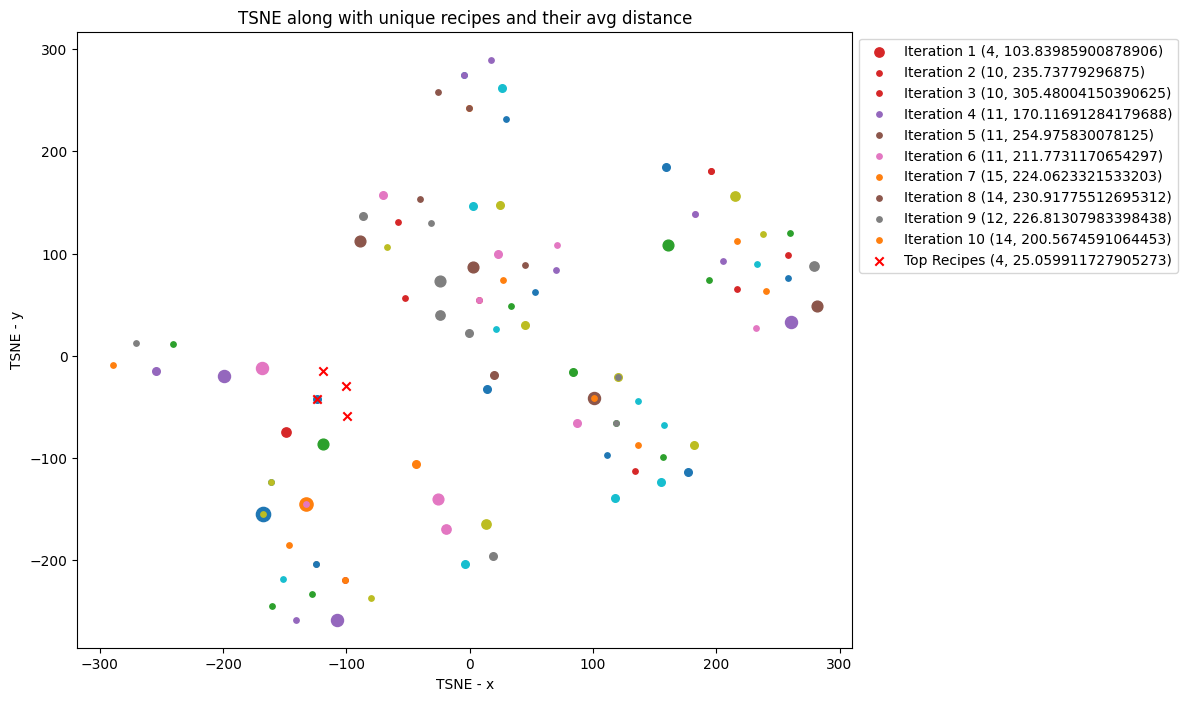

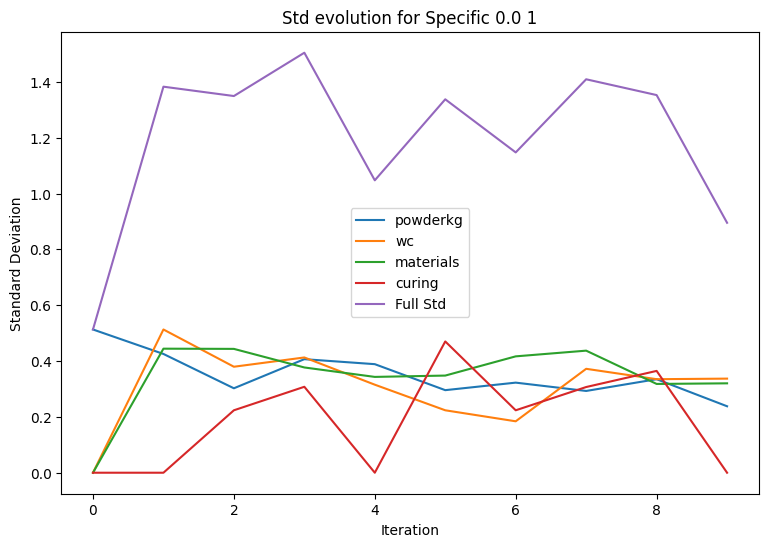

####### Nr of warnings: 0 #######


In [40]:
configs_with_less_than_ten_iterations = 0

std_statistics = pd.DataFrame({
    'configuration': [],
    'mean_std': [],
    'max_std': [],
    'min_std': [],
    'avg_std_gradient': [],
    'initial_std': [],
    'halftime_std': [],
    'final_std': []
})


for combination in all_combinations[5:6]:
    strategy = combination[0]
    temperature = combination[1]
    recursion = combination[2]

    print(f'####### Run with strategy {strategy}, temperature {temperature} and recursion {recursion} #########')

    pattern_0 = fr'gpt-3.5-turbo_{strategy} 0_prompt_experiment_(\d+)_temp_{temperature}_target_(\d+)_\%_Dev_Budget_(\d+)_recursive_{recursion}_(\d+)\.csv'
    pattern_1 = fr'gpt-3.5-turbo_{strategy} 1_prompt_experiment_(\d+)_temp_{temperature}_target_(\d+)_\%_Dev_Budget_(\d+)_recursive_{recursion}_(\d+)\.csv'
    pattern_2 = fr'gpt-3.5-turbo_{strategy} 2_prompt_experiment_(\d+)_temp_{temperature}_target_(\d+)_\%_Dev_Budget_(\d+)_recursive_{recursion}_(\d+)\.csv'

    all_results_df, matching_filenames = extract_data_for_given_run_for_all_variations(pattern_0, pattern_1, pattern_2)

    # TODO: properly handle this case
    number_of_iterations = len(all_results_df)
    if not matching_filenames or number_of_iterations != 10:
        print(f'Warning: Some of the files for {strategy} {temperature} {recursion} have less than 10 rows per dataframe')
        configs_with_less_than_ten_iterations = configs_with_less_than_ten_iterations + 1

    warnings.filterwarnings("default")

    df_powders, df_wc, df_materials, df_curing = get_material_dfs_from_all_results_df()

    max_powders = get_max(df_powders)
    max_wc = get_max(df_wc)
    max_materials = get_max(df_materials)
    max_curing = get_max(df_curing)

    materials_df = MaterialsDataframes(feature_dfs=[df_powders, df_wc, df_materials, df_curing],
                                       max_values=[max_powders, max_wc, max_materials, max_curing])

    df_recipe_vectors = create_recipe_vectors(materials_df)
    top_recipes = find_top_recipes(materials_df.max_values)

    df_recipe_vectors = pd.concat([df_recipe_vectors, top_recipes])
    df_recipe_vectors = df_recipe_vectors.dropna(axis=1)

    tsne_result = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000).fit_transform(df_recipe_vectors.values)

    plot_recipes_in_2d(tsne_result)

    ####### Standard Deviations #######
    std_for_each_run_powder = compute_std_over_different_runs(df_powders, number_of_iterations)
    std_for_each_run_wc = compute_std_over_different_runs(df_wc, number_of_iterations)
    std_for_each_run_materials = compute_std_over_different_runs(df_materials, number_of_iterations)
    std_for_each_run_curing = compute_std_over_different_runs(df_curing, number_of_iterations)

    # TODO:
    std_for_statistics = std_for_each_run_powder + std_for_each_run_wc + std_for_each_run_materials + std_for_each_run_curing

    std_statistics.loc[len(std_statistics)] = {
        'configuration': f'{strategy} {temperature} {recursion}',
        'mean_std': np.mean(std_for_statistics),
        'max_std': np.max(std_for_statistics),
        'min_std': np.min(std_for_statistics),
        'avg_std_gradient': compute_avg_grad(std_for_statistics),
        'initial_std': std_for_statistics[0],
        'halftime_std': std_for_statistics[floor(number_of_iterations / 2)],
        'final_std': std_for_statistics[number_of_iterations - 1],
    }

    nr_iterations = np.arange(0, number_of_iterations)
    plt.figure(figsize=(9, 6))
    plt.plot(nr_iterations, std_for_each_run_powder, label='powderkg')
    plt.plot(nr_iterations, std_for_each_run_wc, label='wc')
    plt.plot(nr_iterations, std_for_each_run_materials, label='materials')
    plt.plot(nr_iterations, std_for_each_run_curing, label='curing')

    plt.plot(nr_iterations, std_for_statistics, label='Full Std')

    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Standard Deviation')
    plt.title(f'Std evolution for {strategy} {temperature} {recursion}')

    plt.show()
#     if full:
#         plt.savefig(f'Results/Recipe_Distribution_Analysis/Full Std evolution for Strategy {strategy} Temperature {temperature} Recursion {recursion}.png', bbox_inches='tight')
#     else:
#         plt.savefig(f'Results/Recipe_Distribution_Analysis/Std evolution for Strategy {strategy} Temperature {temperature} Recursion {recursion}.png', bbox_inches='tight')
#
# if full:
#     std_statistics.to_csv('Results/Recipe_Distribution_Analysis/Full std_statistics.csv')
# else:
#     std_statistics.to_csv('Results/Recipe_Distribution_Analysis/std_statistics.csv')

print(f'####### Nr of warnings: {configs_with_less_than_ten_iterations} #######')